In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from os.path import join
from PIL import Image

In [2]:
def get_dataset_name(nnUNet_raw, dataset_id):
    dataset_id = str(dataset_id).zfill(3)
    dataset_name = [dataset_name for dataset_name in os.listdir(nnUNet_raw) if dataset_name.startswith(f"Dataset{dataset_id}") and os.path.isdir(join(nnUNet_raw, dataset_name))]
    assert len(dataset_name) == 1, f"Found {len(dataset_name)} datasets with id {dataset_id}, expected 1"
    return dataset_name[0]

# 3 splits results analysis

In [112]:
def visualize_outliers(df, model, metric, outliers_dict, nnUNet_raw, test_dataset, show=False):
    # Calculate Q1, Q3, and IQR
    Q1 = df[metric].quantile(0.25)
    Q3 = df[metric].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds (same as boxplot: 1.5 * IQR)
    lower_bound = 60 #Q1 - 1.5 * IQR
    upper_bound = 100
    
    # Filter for outliers
    outliers = df[(df['dice'] < lower_bound) | (df['dice'] > upper_bound)]
    outliers_dict[model] = outliers['image_id'].tolist()
    
    print(f"\n{model}:")
    print(f"  Total images: {len(df)}")
    print(f"  Outliers: {len(outliers)}")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    
    num_outliers = len(outliers)
    
    if num_outliers > 0:
        print(f"  Outlier image IDs:")
        for idx, row in outliers.iterrows():
            print(f"    {row['image_id']}: dice={row['dice']:.2f}")
    
    if show:
        plt.figure(figsize=(15, 8))
        for i, outlier in enumerate(outliers_dict[model]):
            print(f"outlier: {outlier}")
            img_path = f"{nnUNet_raw}/{test_dataset}/imagesTr/{outlier}_0000.png"
            mask_path = f"{nnUNet_raw}/{test_dataset}/labelsTr/{outlier}.png"

            img = np.array(Image.open(img_path))
            mask = np.array(Image.open(mask_path))

            plt.subplot(1, len(outliers_dict[model]), i+1)
            plt.imshow(img, cmap='gray')
            plt.contour(mask, colors='yellow', levels=[0.5])
            plt.axis('off')
            if i == 2:
                break
        plt.show()

    return num_outliers

In [113]:
# These images have wrong annotations

ignore_ids = [
    "Nike_Brian___NIKE_S962_T4_R_CAR_3_1562",
    "Nike_Brian___NIKE_S975_T4_L_CAR_2_752",
    "Nike_XC_Jamil___NIKE_S129_T0_L_CAR_3_1119",
    "Nike_XC_Jamil___NIKE_S129_T0_L_CAR_1_895",
    "Nike_Brian___NIKE_S951_T4_R_CAR_3_1149",
]

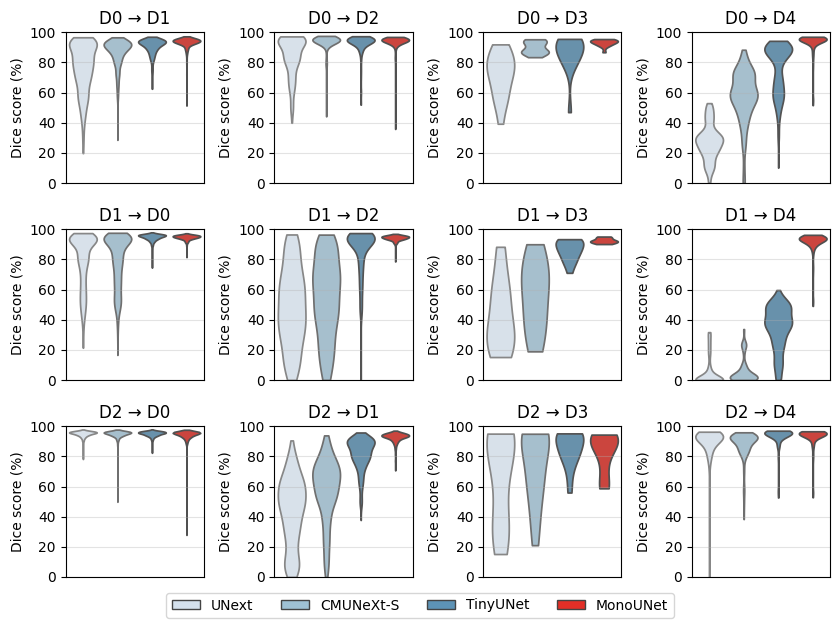

In [296]:
nnUNet_raw = "../knee_us_segmentation/data/nnUNet_raw"
nnUNet_results = "../knee_us_segmentation/data/nnUNet_results"

largest_component = True

models = [
    # "UNext",
    "UNextDA",
    # "CMUNeXt-S",
    "CMUNeXt-SDA",
    # "TinyUNet",
    "TinyUNetDA",
    # "UNet",
    # "MonoUNetBaseDA",
    # "MonoUNetE1",
    # "MonoUNetE1DA_refiner",
    # "MonoUNetBase_refiner",
    # "MonoUNetE1_refiner",
    # "MonoUNetE12DA",
    # "MonoUNetE12_refiner",
    # "MonoUNetE123V2",
    # "MonoUNetE123V2DA",
    "MonoUNetE123V2GatedDA",
    # "MonoUNetE123V2GatedDACascade",
    # "MonoUNetBaseDA",
    # "MonoUNetE1234",
    # "nnunet_xtiny",
    # "nnunet_xtiny_inverted",
    # "nnunet",
    # "XTinyUNetDA",
    # "XTinyMonoUNetScale1",
    # "XTinyMonoUNetScale6",
    # "XTinyMonoUNetScale1_no_ortho",
    # "XTinyMonoUNetScale6_no_ortho",
    # "XTinyMonoV2UNetScale1",
    # "XTinyMonoV2UNetScale6",
    # "XTinyMonoV2GatedUNet",
    # "XTinyMonoV2GatedEncUNetV1",
    # "XTinyMonoV2GatedEncUNetV1DA",
    # "XTinyUNetB",
    # "XTinyUNetBDA",
    # "XTinyMonoV2GatedEncUNetV1BDA",
    # "XTinyUNetL",
    # "XTinyUNetLDA",
    # "XTinyMonoV2GatedEncUNetV1L",
    # "XTinyMonoV2GatedEncUNetV1LDA",
    # "XTinyMonoV2GatedEncUNet",
    # "XTinyMonoV2GatedEncUNetV0",
    # "XTinyMonoV2GatedEncDecUNet",
    # "XTinyMonoUNetgated",
    # "XTinyMonoUNetgatedenc",
    # "XTinyMonoUNetgateddec",
    # "XTinyMonoUNetgatedencdec",
]

train_dataset_ids = [72, 73, 70]
all_test_dataset_ids = [72, 73, 70, 78, 79]
dataset_id2abbr = {
    72: "D0",
    73: "D1",
    70: "D2",
    78: "D3",
    79: "D4",
}
folds = range(3)
metric = "dice"
# metric = "masd"
# metric = "hd95"

# Define colors for each model using seaborn palette
from matplotlib.patches import Patch
# colors = sns.color_palette(n_colors=len(models))
colors = sns.color_palette("Blues", n_colors=len(models), desat=0.7)[:-1] + [sns.color_palette("Reds", n_colors=2)[-1]] #sns.color_palette(n_colors=1)

fig = plt.figure(figsize=(8.5, 6))
legend_handles = []
legend_labels = []

for i, train_dataset_id in enumerate(train_dataset_ids):
    test_dataset_ids = all_test_dataset_ids.copy()
    test_dataset_ids.remove(train_dataset_id)
    for j, test_dataset_id in enumerate(test_dataset_ids):
        train_dataset = get_dataset_name(nnUNet_raw, train_dataset_id)
        test_dataset = get_dataset_name(nnUNet_raw, test_dataset_id)

        plt.subplot(len(train_dataset_ids), len(test_dataset_ids), i * len(test_dataset_ids) + j + 1)
        
        outliers_dict = {k: [] for k in models}
        
        for model_idx, model in enumerate(models):
            if metric != 'dice' and model == 'UNextDA':
                continue

            # Collect data across all folds for this model
            all_scores = []
            
            for fold in folds:
                # print(f"model: {model}")
                # print(f"train_dataset_id: {train_dataset_id}")
                # print(f"test_dataset_id: {test_dataset_id}")
                
                if train_dataset == test_dataset:
                    image_wise_results_path = f"models/{model}/{train_dataset}/image_wise_results_largest_component_{test_dataset}.csv"
                else:
                    image_wise_results_path = f"models/{model}/{train_dataset}/fold_{fold}/test/image_wise_results_largest_component_{test_dataset}.csv"
                
                if not os.path.exists(image_wise_results_path):
                    print(f"Skipping {model} fold {fold} - missing {image_wise_results_path}")
                    continue
                # print(f"image_wise_results_path: {image_wise_results_path}")
                df = pd.read_csv(image_wise_results_path)
                # ignore the ignore ids
                df = df[~df['image_id'].isin(ignore_ids)]
                
                # Collect scores from this fold
                all_scores.append(df[metric].values)
                
                # if test_dataset == "Dataset070_Clarius_L15" and model == "MonoUNetE123V2GatedDA":
                #     print(test_dataset)
                #     visualize_outliers(df, model, outliers_dict, nnUNet_raw, test_dataset)

            if len(all_scores) == 0:
                continue

            all_scores = np.array(all_scores)
            all_scores = all_scores.mean(axis=0).tolist()
            
            # Create legend entry (only once per model, in first subplot)
            if i == 0 and j == 0:
                model_display_name = model.replace("MonoUNetE123V2GatedDA", "MonoUNet")
                model_display_name = model_display_name.replace("UNextDA", "UNext")
                model_display_name = model_display_name.replace("CMUNeXt-SDA", "CMUNeXt-S")
                model_display_name = model_display_name.replace("TinyUNetDA", "TinyUNet")
                legend_handles.append(Patch(facecolor=colors[model_idx], edgecolor="#444444"))
                legend_labels.append(model_display_name)
            
            # sns.boxplot(x=[model_idx] * len(all_scores), y=all_scores, width=0.35, notch=False, 
            #             showmeans=False, color=colors[model_idx])
            sns.violinplot(x=[model] * len(all_scores), y=all_scores, 
                           width=0.8, inner=None, cut=0, color=colors[model_idx])
            # sns.stripplot(x=[model] * len(all_scores), y=all_scores, 
            #             color='k', size=0.5, jitter=True, alpha=0.5)

        if metric == 'dice':
            plt.ylim(0, 100)
            plt.ylabel('Dice score (%)')
        elif metric == 'hd95':
            # plt.yscale('log')
            plt.ylim(0, 210)
            plt.ylabel('HD95 (px)')
        elif metric == 'masd':
            plt.yscale('log')
            plt.ylim(0.1, 80)
            plt.ylabel('MASD (px)')
        plt.xticks([])  # Remove x-axis labels
        # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))
        plt.title(f'{dataset_id2abbr[train_dataset_id]} → {dataset_id2abbr[test_dataset_id]}')
        plt.grid(True, axis='y', alpha=0.35)

# Add legend at the bottom center of the figure
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(models), 
           bbox_to_anchor=(0.5, -0.05), frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.03)  # Make room for legend
plt.savefig(f'results/quantitative/ood_performance_plots_{metric}.svg', dpi=300)
plt.show()

## Tabulate results

In [346]:
train_dataset_id = 72
test_dataset_ids = [73, 70, 78, 79]

folds = range(3)
metrics = ["dice", "masd"]

train_dataset = get_dataset_name(nnUNet_raw, train_dataset_id)

# Dynamically create column names for dice and masd for each test dataset
avg_columns = ["model", "params", "flops"]
for tid in test_dataset_ids:
    abbr = dataset_id2abbr[tid]
    avg_columns.append(f"{abbr} dice")
    avg_columns.append(f"{abbr} masd")
avg_df = pd.DataFrame(columns=avg_columns)

for model_idx, model in enumerate(models):
    # Compute params and flops once per model
    model_analysis_path = f"models/{model}/model_analysis.json"
    with open(model_analysis_path, 'r') as f:
        model_analysis = json.load(f)
    params = model_analysis['parameters']['total'] / 1e6
    params = round(params, 3)
    flops = model_analysis['flops']['giga']
    
    model_name = model.replace("MonoUNetE123V2GatedDA", "MonoUNet")
    model_name = model_name.replace("UNextDA", "UNext")
    model_name = model_name.replace("CMUNeXt-SDA", "CMUNeXt-S")
    model_name = model_name.replace("TinyUNetDA", "TinyUNet")

    row = [model_name, params, flops]
    
    # Collect results for all test datasets
    for j, test_dataset_id in enumerate(test_dataset_ids):
        test_dataset = get_dataset_name(nnUNet_raw, test_dataset_id)
        # print(f"Test dataset: {dataset_id2abbr[test_dataset_id]}")
        # print("=================================")
        
        # Collect data across all folds for this model and test dataset
        all_scores = []
        
        for fold in folds:
            # print(f"model: {model}")
            # print(f"train_dataset_id: {train_dataset_id}")
            # print(f"test_dataset_id: {test_dataset_id}")
            
            if train_dataset == test_dataset:
                image_wise_results_path = f"models/{model}/{train_dataset}/image_wise_results_largest_component_{test_dataset}.csv"
            else:
                image_wise_results_path = f"models/{model}/{train_dataset}/fold_{fold}/test/image_wise_results_largest_component_{test_dataset}.csv"
            
            
            if not os.path.exists(image_wise_results_path):
                print(f"Skipping {model} fold {fold} - missing {image_wise_results_path}")
                continue

            # print(f"image_wise_results_path: {image_wise_results_path}")
            df = pd.read_csv(image_wise_results_path)
            # ignore the ignore ids
            df = df[~df['image_id'].isin(ignore_ids)]
            
            # Collect scores from this fold
            all_scores.append(df[metrics].values)
        
        all_scores = np.array(all_scores)
        all_scores = all_scores.mean(axis=0).mean(axis=0).round(2)
        # Append dice and masd for this test dataset
        row.append(all_scores[0])  # dice
        row.append(all_scores[1])  # masd

    # Append row to dataframe
    avg_df.loc[len(avg_df)] = row

avg_df.set_index('model', inplace=True)
avg_df

,params,flops,D1 dice,D1 masd,D2 dice,D2 masd,D3 dice,D3 masd,D4 dice,D4 masd
model,,,,,,,,,,
UNext,1.472,4.59,76.31,2.26,83.80,2.19,71.80,2.81,27.39,17.06
CMUNeXt-S,0.418,2.18,86.43,1.09,93.04,0.77,89.87,1.11,57.38,3.93
TinyUNet,0.481,3.33,90.40,0.92,92.56,0.79,86.02,1.17,75.72,2.54
MonoUNet,0.002,0.15,93.02,0.87,93.77,0.79,93.10,0.88,93.43,2.00


# Dice vs params comparison

model: UNextDA
params: 1.47
flops: 4.59
model: CMUNeXt-SDA
params: 0.42
flops: 2.18
model: TinyUNetDA
params: 0.48
flops: 3.33
model: MonoUNetE123V2GatedDA
params: 0.0
flops: 0.15


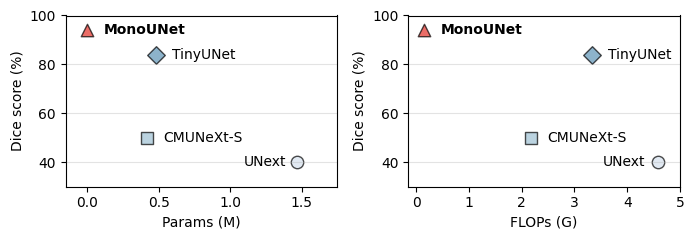

In [347]:
train_dataset_id = 73
test_dataset_id = 70
fold = 0

train_dataset = get_dataset_name(nnUNet_raw, train_dataset_id)
test_dataset = get_dataset_name(nnUNet_raw, test_dataset_id)

plt.figure(figsize=(7, 2.5))

markers = ['o', 's', 'D', '^', 'X', 'v', '^', '<', '>', 'p', 'h', 'H', '8', '1']

for model_idx, model in enumerate(models):
    print(f"model: {model}")
    image_wise_results_path = f"models/{model}/{train_dataset}/fold_{fold}/test/image_wise_results_largest_component_{test_dataset}.csv"
    model_analysis_path = f"models/{model}/model_analysis.json"
    with open(model_analysis_path, 'r') as f:
        model_analysis = json.load(f)
    params = model_analysis['parameters']['total_millions']
    flops = model_analysis['flops']['giga']
    print(f"params: {params}")
    print(f"flops: {flops}")
    
    if not os.path.exists(image_wise_results_path):
        print(f"Skipping {model} fold {fold} - missing {image_wise_results_path}")
        continue
    
    df = pd.read_csv(image_wise_results_path)
    df = df[~df['image_id'].isin(ignore_ids)]
    score = df[metric].values.mean().round(2)
    
    model_display_name = model.replace("MonoUNetE123V2GatedDA", "MonoUNet")
    model_display_name = model_display_name.replace("UNextDA", "UNext")
    model_display_name = model_display_name.replace("CMUNeXt-SDA", "CMUNeXt-S")
    model_display_name = model_display_name.replace("TinyUNetDA", "TinyUNet")
    
    for i, item in enumerate([params, flops]):
        plt.subplot(1, 2, i+1)
        plt.scatter([item], [score], 
                    color=colors[model_idx], edgecolor='k', s=80, alpha=0.7, marker=markers[model_idx])
                    
        # Use a proportionate horizontal offset based on x-axis range for each subplot
        ax = plt.gca()
        x_limits = ax.get_xlim()
        x_range = x_limits[1] - x_limits[0]
        offset = x_range * 0.06  # 4% of axis range

        if model_display_name == "MonoUNet":
            plt.text(item + offset, score, model_display_name, fontsize=10, ha='left', va='center', fontweight='bold')
        elif model_display_name == "UNext":
            plt.text(item - 8 * offset, score, model_display_name, fontsize=10, ha='right', va='center')
        else:
            plt.text(item + offset, score, model_display_name, fontsize=10, ha='left', va='center')
        
        plt.grid(True, axis='y', alpha=0.35)
        plt.ylabel('Dice score (%)')
        plt.ylim(30, 100)
        if item == params:
            plt.xlim(-0.15, 1.75)
        if item == flops:
            plt.xlim(-0.15, 5)

        if item == params:
            plt.xlabel('Params (M)')
        else:
            plt.xlabel('FLOPs (G)')
            plt.ylabel('Dice score (%)')

# plt.suptitle(f'{dataset_id2abbr[train_dataset_id]} → {dataset_id2abbr[test_dataset_id]}')
plt.tight_layout()
plt.savefig(f'results/quantitative/params_flops_vs_{metric}.svg', dpi=300)
plt.show()

# Qualitative results

Using first 5 available images
Original image not found: /home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset078_KneeUS_OtherDevices/imagesTs/subject_0_cephasonics_20250820_203856_playback_000370_667_0000.png
Original image not found: /home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset078_KneeUS_OtherDevices/imagesTs/subject_0_clarius_MSK_9_1233_0000.png
Original image not found: /home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset078_KneeUS_OtherDevices/imagesTs/subject_0_cephasonics_20250820_204306_playback_000383_290_0000.png
Original image not found: /home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset078_KneeUS_OtherDevices/imagesTs/subject_0_cephasonics_20250820_203856_playback_000564_1687_0000.png
Original image not found: /home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw/Dataset078_KneeUS_OtherDevices/imagesTs/subject_0_cephasonics_20250820_203856_playback_000095_387_0000.png

Image: subject_0_cephasonics_20250820_203856_p

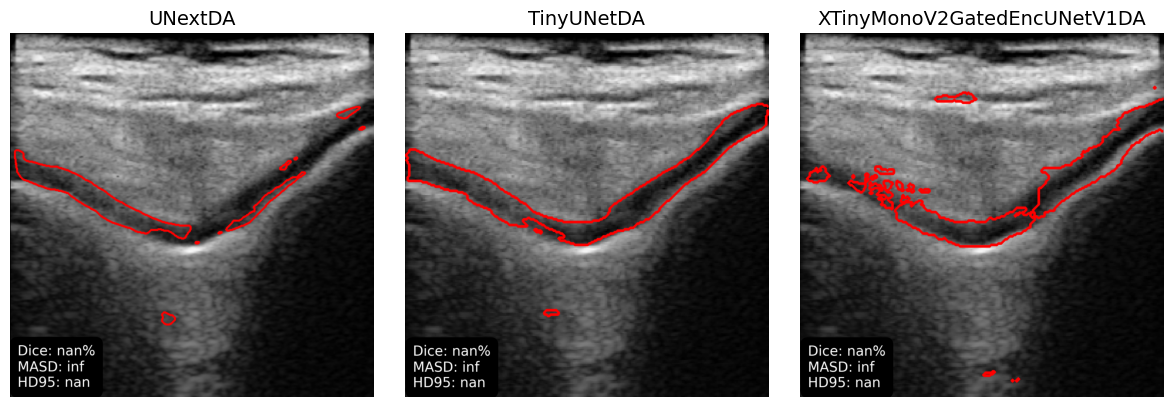


Image: subject_0_clarius_MSK_9_1233 | Dataset: Dataset078_KneeUS_OtherDevices | Fold: 0


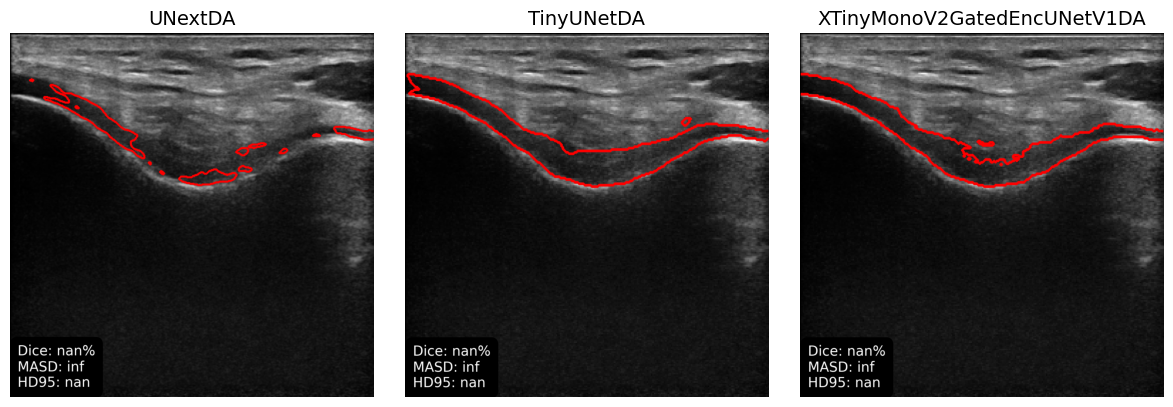


Image: subject_0_cephasonics_20250820_204306_playback_000383_290 | Dataset: Dataset078_KneeUS_OtherDevices | Fold: 0


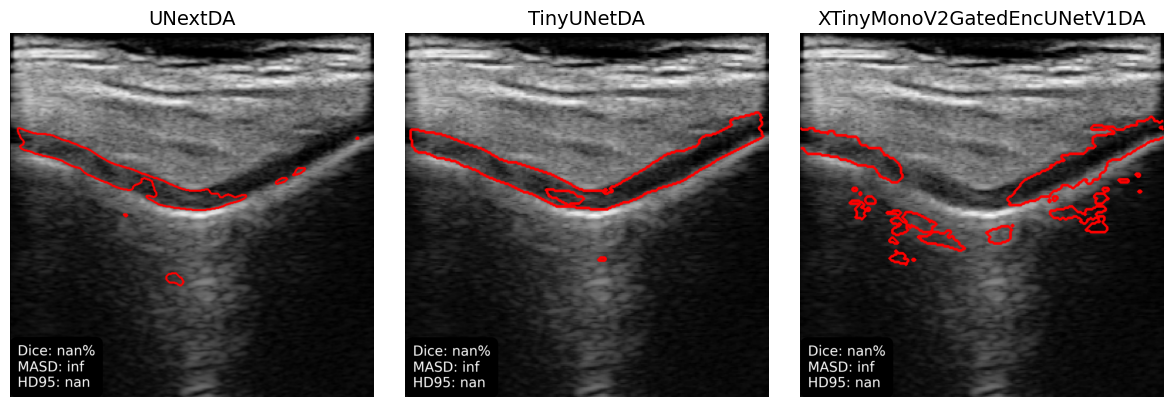


Image: subject_0_cephasonics_20250820_203856_playback_000564_1687 | Dataset: Dataset078_KneeUS_OtherDevices | Fold: 0


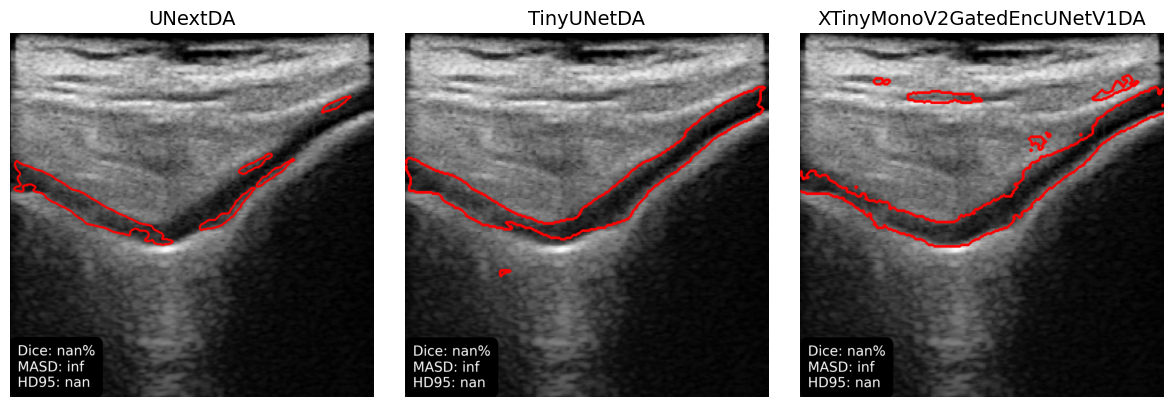


Image: subject_0_cephasonics_20250820_203856_playback_000095_387 | Dataset: Dataset078_KneeUS_OtherDevices | Fold: 0


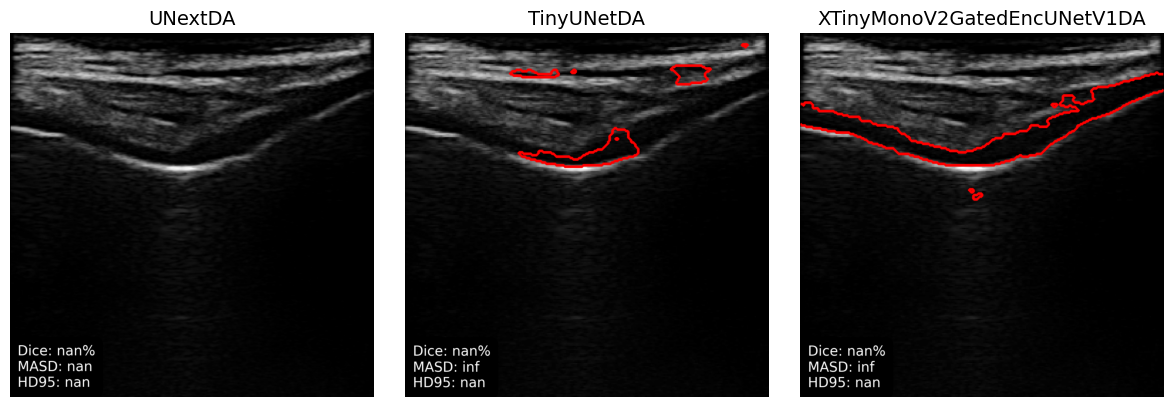


Displayed 3 models for 5 image(s)
Available images: 1704 total
To view more images, increase num_images (currently 5)


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Configuration - modify these to select what to visualize
train_dataset = "Dataset073_GE_LE"  # Training dataset
test_dataset = "Dataset078_KneeUS_OtherDevices"  # Test dataset to visualize
fold = 0  # Fold number (0-4)
image_name = None  # Specific image name (e.g., "subject_0_clarius_MSK_1_1689.png") or None to use first available
num_images = 5  # Number of images to display (will use first N available images if image_name is None)

# List of models to visualize (using the same list from Cell 2)
models = [
    "UNextDA",
    "CMUNeXt-SDA",
    "TinyUNetDA", 
    "XTinyUNetDA",
    "XTinyMonoV2GatedEncUNetV1DA",
]

# Find available overlay images
overlay_dir_template = "models/{model}/{train_dataset}/fold_{fold}/test/{test_dataset}/overlays"

# Get list of available images from first model that has overlays
available_images = []
for model in models:
    overlay_dir = overlay_dir_template.format(
        model=model, train_dataset=train_dataset, fold=fold, test_dataset=test_dataset
    )
    if os.path.exists(overlay_dir):
        available_images = sorted([f for f in os.listdir(overlay_dir) if f.endswith('.png')])
        break

# Shuffle the images
random.shuffle(available_images)

if not available_images:
    print(f"No overlay images found for {test_dataset} in fold {fold}")
else:
    # Select images to visualize
    if image_name is not None:
        if image_name not in available_images:
            print(f"Warning: {image_name} not found. Using first available: {available_images[0]}")
            images_to_display = [available_images[0]]
        else:
            images_to_display = [image_name]
    else:
        if num_images == -1:
            images_to_display = available_images
            print(f"Using all {len(images_to_display)} available images")
        else:
            images_to_display = available_images[:num_images]
            print(f"Using first {len(images_to_display)} available images")
    
    # Load overlay images for all models and all selected images
    overlay_images = {}  # {image_name: {model: img_array}}
    available_models = []
    
    # First, determine which models are available
    for model in models:
        overlay_path = os.path.join(
            overlay_dir_template.format(
                model=model, train_dataset=train_dataset, fold=fold, test_dataset=test_dataset
            ),
            images_to_display[0]
        )
        if os.path.exists(overlay_path):
            available_models.append(model)
    
    # Load images for all models and all selected images
    for img_name in images_to_display:
        overlay_images[img_name] = {}
        for model in available_models:
            overlay_path = os.path.join(
                overlay_dir_template.format(
                    model=model, train_dataset=train_dataset, fold=fold, test_dataset=test_dataset
                ),
                img_name
            )
            if os.path.exists(overlay_path):
                img = np.array(Image.open(overlay_path))
                overlay_images[img_name][model] = img
            else:
                print(f"Overlay not found for {model}: {overlay_path}")
    
    if not overlay_images:
        print("No overlay images found for any model!")
    else:
        # Display each image in a separate figure with all models
        n_models = len(available_models)
        
        # Load original images from nnUNet dataset
        nnunet_raw = "/home/ultrai/UltrAi/knee_us_segmentation/data/nnUNet_raw"
        original_images = {}
        
        # Determine test split based on dataset name
        if test_dataset == "Dataset078_KneeUS_OtherDevices":
            test_split = "Ts"
        else:
            test_split = "Tr"
        
        dataset_json_path = os.path.join(nnunet_raw, test_dataset, 'dataset.json')
        if os.path.exists(dataset_json_path):
            import json
            with open(dataset_json_path, 'r') as f:
                dataset_info = json.load(f)
            img_ext = dataset_info.get('file_ending', '.png')
            img_dir = os.path.join(nnunet_raw, test_dataset, f'images{test_split}')
            
            for img_name in images_to_display:
                img_id = os.path.splitext(img_name)[0]
                img_path = os.path.join(img_dir, f'{img_id}_0000{img_ext}')
                if os.path.exists(img_path):
                    img = np.array(Image.open(img_path))
                    if len(img.shape) == 2:
                        original_images[img_name] = img
                    elif len(img.shape) == 3 and img.shape[2] == 1:
                        original_images[img_name] = img[:, :, 0]
                    else:
                        # Convert to grayscale if RGB
                        original_images[img_name] = np.array(Image.open(img_path).convert('L'))
                else:
                    print(f"Original image not found: {img_path}")
        
        for img_name in images_to_display:
            print(f'\nImage: {os.path.splitext(img_name)[0]} | Dataset: {test_dataset} | Fold: {fold}')
            
            # Create a separate figure for each image (original + all models)
            n_cols = n_models + (1 if img_name in original_images else 0)
            fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))
            if n_cols == 1:
                axes = [axes]
            
            col_idx = 0
            
            # Display original image first if available
            if img_name in original_images:
                ax = axes[col_idx]
                # Get target size from overlay image
                if available_models and available_models[0] in overlay_images[img_name]:
                    overlay_shape = overlay_images[img_name][available_models[0]].shape
                    target_size = (overlay_shape[1], overlay_shape[0])  # (width, height)
                    original_img = Image.fromarray(original_images[img_name])
                    original_img = original_img.resize(target_size, Image.Resampling.LANCZOS)
                    original_img = np.array(original_img)
                else:
                    original_img = original_images[img_name]
                ax.imshow(original_img, cmap='gray')
                ax.set_title('Input image', fontsize=14)
                ax.axis('off')
                col_idx += 1
            
            # Display all models for this image
            for model_idx, model in enumerate(available_models):
                ax = axes[col_idx]
                if model in overlay_images[img_name]:
                    img = overlay_images[img_name][model]
                    ax.imshow(img)
                    ax.set_title(model, fontsize=14)
                else:
                    ax.axis('off')
                ax.axis('off')
                col_idx += 1
            
            plt.tight_layout()
            plt.show()
        
        print(f"\nDisplayed {len(available_models)} models for {len(images_to_display)} image(s)")
        print(f"Available images: {len(available_images)} total")
        if len(available_images) > len(images_to_display):
            print(f"To view more images, increase num_images (currently {num_images})")

